In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from tqdm import tqdm

In [19]:
#Load the data
df = pd.read_csv("T-20 World cup 2022.csv")

In [20]:
## Display the first few rows of the dataframe
df.head()

,comment_id,match_id,match_name,home_team,away_team,current_innings,innings_id,over,ball,runs,...,wicket_id,wkt_batsman_name,wkt_bowler_name,wkt_batsman_runs,wkt_batsman_balls,wkt_text,isRetiredHurt,text,preText,postText
0,130,1298179,ENG v PAK,PAK,ENG,PAK,1,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,"short again, and he gets some extra bounce on ...",NaN,NaN
1,120,1298179,ENG v PAK,PAK,ENG,PAK,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,False,and he'll have to bowl another free-hit after ...,<p>Free-hit</p>,NaN
2,110,1298179,ENG v PAK,PAK,ENG,PAK,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,False,"full, and a hint of shape away from off stump....","<p><b>6.58pm</b> Thanks, Andrew M. The MCG is ...",NaN
3,140,1298179,ENG v PAK,PAK,ENG,PAK,1,1,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,False,"shortish, angling down leg, gloves a pull down...",NaN,NaN
4,150,1298179,ENG v PAK,PAK,ENG,PAK,1,1,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,"length ball close to off stump, straightens a ...",NaN,NaN


In [21]:
df.shape

(9814, 44)

In [22]:
# Get number of unique values in each column - helps identify categorical and continuous variables.
df.nunique()

comment_id            316
match_id               42
match_name             42
home_team              16
away_team              15
current_innings        16
innings_id              2
over                   20
ball                    6
runs                    8
shortText            5896
isBoundary              2
isWide                  2
isNoball                2
batsman1_id           197
batsman1_name         197
batsman1_runs         104
batsman1_balls         64
bowler1_id            132
bowler1_name          132
bowler1_overs          25
bowler1_maidens         3
bowler1_runs           59
bowler1_wkts            6
batsman2_id           190
batsman2_name         190
batsman2_runs          93
batsman2_balls         61
bowler2_id            132
bowler2_name          132
bowler2_overs           8
bowler2_maidens         3
bowler2_runs           51
bowler2_wkts            5
wicket_id             172
wkt_batsman_name      172
wkt_bowler_name       113
wkt_batsman_runs       68
wkt_batsman_

In [23]:
# Check for missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
missing_values

wkt_text             9263
wkt_batsman_balls    9263
wkt_batsman_runs     9263
wkt_bowler_name      9263
wkt_batsman_name     9263
wicket_id            9263
postText             8726
preText              7953
bowler2_maidens       526
bowler2_id            526
bowler2_name          526
bowler2_overs         526
bowler2_wkts          526
bowler2_runs          526
text                   28
dtype: int64

In [ ]:
"""The dataset contains missing values in several columns. 
The columns related to wickets (wkt_text, wkt_batsman_balls, wkt_batsman_runs, 
wkt_bowler_name, wkt_batsman_name, wicket_id) have the most missing values, 
which is expected as not every ball results in a wicket. 
Other columns with missing values include postText, preText, and various columns related 
to the second bowler (bowler2_*). The text column also has a few missing entries."""

In [24]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
duplicate_rows

1

In [26]:
# Remove duplicate rows
df = df.drop_duplicates()

In [27]:
df.shape

(9813, 44)

In [ ]:
#The duplicate row has been removed, and the dataset now contains 9813 rows and 44 columns.

In [28]:
# Identify outliers in the 'runs' column
# I will use the IQR method to detect outliers
Q1 = df['runs'].quantile(0.25)
Q3 = df['runs'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Findinfg the outliers
outliers = df[(df['runs'] < lower_bound) | (df['runs'] > upper_bound)]['runs']
outliers.describe()

count    1374.000000
mean        4.416303
std         0.950285
min         3.000000
25%         4.000000
50%         4.000000
75%         5.000000
max         7.000000
Name: runs, dtype: float64

In [ ]:
""""There are 1374 outliers in the 'runs' column, with a mean of approximately 4.42 runs. 
These outliers are likely due to scoring events such as boundaries (fours (4 runs) and sixes (6 runs)), 
which are less frequent but still common in T20 cricket. 
Given the nature of the sport, these are not errors but an integral part of the game, so we will not remove them.
"""

In [29]:
# Check the unique values of categorical variables
categorical_columns = df.select_dtypes(include=['object']).columns
unique_values = df[categorical_columns].nunique().sort_values()
unique_values

away_team             15
home_team             16
current_innings       16
match_name            42
wkt_bowler_name      113
bowler1_name         132
bowler2_name         132
wkt_batsman_name     172
batsman2_name        190
batsman1_name        197
wkt_text             551
postText            1084
preText             1830
shortText           5896
text                9705
dtype: int64

 Creating new features that could be useful for analysis, such as the strike rate of batsmen, economy rate of bowlers, or total boundaries hit in an innings.

In [31]:
# Calculate the strike rate for batsmen
# Strike Rate = (Total Runs Scored / Total Balls Faced) * 100

df['batsman1_strike_rate'] = (df['batsman1_runs'] / df['batsman1_balls']) * 100

df['batsman2_strike_rate'] = (df['batsman2_runs'] / df['batsman2_balls']) * 100

In [33]:
# Calculate the economy rate for bowlers
# Economy Rate = (Total Runs Conceded / Total Overs Bowled)
df['bowler1_economy_rate'] = df['bowler1_runs'] / df['bowler1_overs']
df['bowler2_economy_rate'] = df['bowler2_runs'] / df['bowler2_overs']

In [34]:
# Calculate the total boundaries hit in an innings
# Boundaries are 4s and 6s, we'll assume 'isBoundary' column indicates a boundary
boundaries_data = df[df['isBoundary'] == True]
innings_boundaries = boundaries_data.groupby('innings_id')['isBoundary'].count().reset_index()
innings_boundaries.rename(columns={'isBoundary': 'total_boundaries'}, inplace=True)


In [35]:
# Merge the total boundaries back to the main dataframe
result = df.merge(innings_boundaries, on='innings_id', how='left')

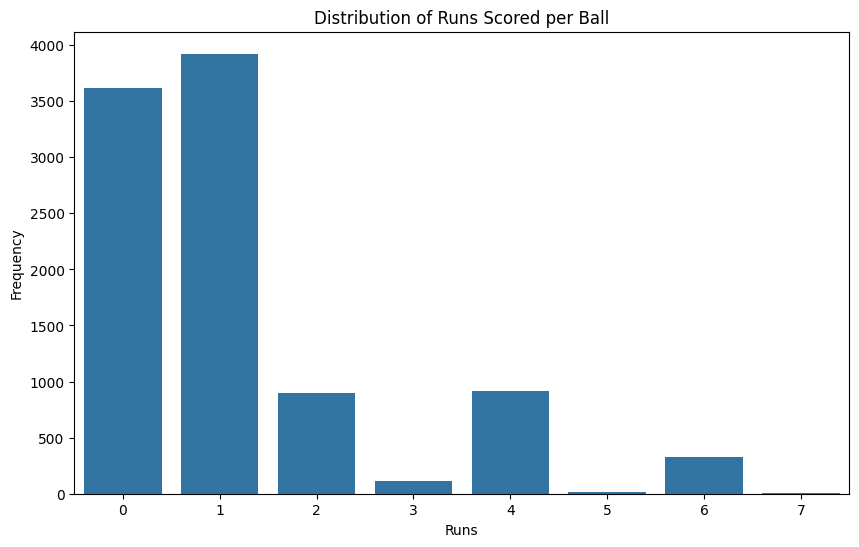

In [39]:
# Plot distribution of runs scored per ball
plt.figure(figsize=(10, 6))
sns.countplot(x='runs', data=df)
plt.title('Distribution of Runs Scored per Ball')
plt.xlabel('Runs')
plt.ylabel('Frequency')
plt.show()

In [40]:
# Group by batsman and sum the runs
batsman_runs = df.groupby('batsman1_name')['runs'].sum().sort_values(ascending=False)

# Get the top 10 batsmen
batsman_runs.head(10)

batsman1_name
Virat Kohli         310
Max O'Dowd          261
Jos Buttler         241
Suryakumar Yadav    236
Pathum Nissanka     232
Sikandar Raza       230
Kusal Mendis        229
Alex Hales          218
Lorcan Tucker       217
Glenn Phillips      209
Name: runs, dtype: int64

Virat Kohli is at the top position with the 310 runs scored by him 

In [41]:
# Group by bowler and count the number of wickets
bowler_wickets = df.groupby('bowler1_name')['wicket_id'].nunique().sort_values(ascending=False)

# Get the top 10 bowlers
bowler_wickets.head(10)

bowler1_name
Wanindu Hasaranga de Silva    14
Paul van Meekeren             13
Bas de Leede                  13
Sam Curran                    13
Blessing Muzarabani           12
Anrich Nortje                 12
Shadab Khan                   12
Maheesh Theekshana            11
Josh Little                   11
Shaheen Shah Afridi           11
Name: wicket_id, dtype: int64

Wanindu Hasaranga de Silva is at the top with 14 wickets.


analyzing the performance of each team in terms of total runs scored and total wickets taken.
To shows the performance of each team in terms of total runs scored and total wickets taken.
We will create two new columns named as "batting_team" and "bowling_team".

In [44]:
# Create new 'batting_team' and 'bowling_team' columns
df['batting_team'] = np.where(df['current_innings'] == df['home_team'], df['home_team'], df['away_team'])
df['bowling_team'] = np.where(df['batting_team'] == df['home_team'], df['away_team'], df['home_team'])

In [47]:
# Calculating the total runs scored by each team
team_runs = df.groupby('batting_team')['runs'].sum().sort_values(ascending=False)
team_runs


batting_team
SL       1097
IRE      1045
ZIM      1010
NED      1007
INDIA    1004
PAK       979
NZ        854
ENG       848
BAN       665
SA        637
AUS       598
SCOT      467
NAM       424
AFG       419
WI        410
UAE       331
Name: runs, dtype: int64

In [49]:
# Calculating the total wickets taken by each team
team_wickets = df.groupby('bowling_team')['wicket_id'].nunique().sort_values(ascending=False)
team_wickets

bowling_team
SL       53
NED      51
PAK      49
ENG      47
ZIM      45
INDIA    37
NZ       37
SA       36
BAN      33
IRE      33
AUS      25
UAE      22
SCOT     18
AFG      17
NAM      17
WI       16
Name: wicket_id, dtype: int64

In [61]:
# Combining both metrics into a single dataframe to get total runs and total wickets 
team_performance = pd.DataFrame({'Total Runs': team_runs, 'Total Wickets': team_wickets}).reset_index()
team_performance 

,index,Total Runs,Total Wickets
0,0,419,17
1,1,598,25
2,2,665,33
3,3,848,47
4,4,1004,37
5,5,1045,33
6,6,424,17
7,7,1007,51
8,8,854,37
9,9,979,49


Sri Lanka (SL) has taken the most wickets with a total of 53, while 
India (IND) has scored the most runs with a total of 1004.